#載入檔案

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#載入訓練用資料
import pandas as pd
import numpy as np
data = pd.read_csv('/content/drive/MyDrive/train.csv')
data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [ ]:
#列出欄位名稱
data.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [ ]:
data.shape

(165034, 14)

In [ ]:
# 刪除 Exited為空值的資料列
data = data.dropna(subset=['Exited'])

In [ ]:
data.shape

(165034, 14)

# 自動前處理 (自製)

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
class AutoPreprocess:
    def __init__(self):
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []

    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names

        for fname in field_names:
            #自動補空值
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
                # self.fillna_value[fname] = 'np.nan'
                # self.fillna_value[fname] = np.nan # 維持空值
            elif data[fname].dtype == bool: #布林型態
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
            else: # 數字型態
                self.fillna_value[fname] = data[fname].median()  #補中位數

            #自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                pass #不用轉換
            elif data[fname].dtype == bool: #布林型態
                pass #不用轉換
            else: # 數字型態
                vc = data[fname].value_counts()
                if data[fname].isin([0, 1]).all(): #當數值只有0跟1
                    pass #不用轉換
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10: #是否簡單的整數型類別且數量小於10
                    self.scaler[fname] = MinMaxScaler()
                    self.scaler[fname].fit(data[[fname]])
                else: #其他的數字型態
                    self.scaler[fname] = StandardScaler()
                    self.scaler[fname].fit(data[[fname]])


            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = fname+"_"+value
                    # data[fn] = (data[fname] == value).astype('int8')
                    self.final_field_names.append(fn)
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                # data[fname] = data[fname].astype(int)
                self.final_field_names.append(fname)
            else: # 數字型態 不用重新編碼
                self.final_field_names.append(fname)

        return

    def transform(self, data):
        #如果輸入的data是dict，要先轉成dataframe
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else: #將資料複製一份，不修改原本的資料
            data = data.copy()

        for fname in self.field_names:
            #自動補空值
            if data[fname].isnull().any(): #有空值
                # if fname in self.fillna_value:
                    data[fname] = data[fname].fillna(self.fillna_value[fname])


            #自動尺度轉換(scaling)
            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])

            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                if fname in self.onehotencode_value:
                    field_value = self.onehotencode_value[fname]
                for value in field_value:
                    fn = fname+"_"+value
                    data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                data[fname] = data[fname].astype(int)
            else: # 數字型態 不用重新編碼
                pass
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)

In [ ]:
# # AutoPreprocess Example
# ####################################################
# # Train Step
# mydata = pd.read_csv('../data/Automobile_Train.csv')
# ap = AutoPreprocess()
# ap.fit(mydata, ['symboling', 'Normalized-losses', 'make', 'Fuel-type', 'aspiration',
#        'Num-of-doors', 'Body-style', 'Drive-wheels', 'Engine-location',
#        'Wheel-base', 'length', 'width', 'height', 'Curb-weight', 'Engine-type',
#        'Num-of-cylinders', 'Engine-size', 'Fuel-system', 'bore', 'stroke',
#        'Compression-ratio', 'horsepower', 'Peak-rpm', 'City-mpg',
#        'Highway-mpg'])
# ap.save("C:/DATA/test.bin")

# ####################################################
# # Test and inference
# ap2 = AutoPreprocess.load("C:/DATA/test.bin")
# d2 = ap2.transform(mydata) #Pandas Dataframe
# d2.head()

# ####################################################
# # Test and inference with one record
# ap2 = AutoPreprocess.load("C:/DATA/test.bin")
# data_dict = {"symboling":1, "aspiration":"std"}
# d2 = ap2.transform(data_dict) #Python Dict
# print(d2)


# 前處理

In [ ]:
ap = AutoPreprocess()
ap.fit(data, ['CustomerId', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'])

ap.save("/content/drive/MyDrive/preprocess_RFC.bin")


X = ap.transform(data)
y = data['Exited']

In [ ]:
X.columns

Index(['CustomerId', 'CreditScore', 'Geography_France', 'Geography_Spain',
       'Geography_Germany', 'Gender_Male', 'Gender_Female', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split
# 資料集分割：將資料集分成訓練集和測試集，80% 用於訓練，20% 用於測試
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

#訓練模型

In [ ]:
# 訓練模型
# from sklearn.tree import DecisionTreeRegressor
# model = DecisionTreeRegressor()

# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(
#     n_estimators=1000, # 樹數量可以拉高到 300~500，讓模型更穩定
#     max_depth=20, # 限制深度，例如 10~20（預設是None，建議要限制）
#     min_samples_split=20, # 每個節點至少 20 筆資料才分裂
#     min_samples_leaf=10, # 葉節點最少要 10 筆資料，防止過細分裂
#     max_features='sqrt', # 每次分裂考慮的特徵數，sqrt 在高維特徵中表現穩定
#     random_state=42
# )

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

# from sklearn.svm import SVR
# model = SVR(kernel='rbf')

model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# 驗證模型
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,recall_score,precision_score,roc_auc_score

y_pred = model.predict(X_train)
f1 = f1_score(y_train, y_pred)
print("訓練組 f1:", f1)
precision = precision_score(y_train, y_pred)
print("訓練組 precision:", precision)
recall = recall_score(y_train, y_pred)
print("訓練組 recall:", recall)
roc_auc = roc_auc_score(y_train, y_pred)
print("訓練組 roc_auc:", roc_auc)

y_pred = model.predict(X_valid)
f1 = f1_score(y_valid, y_pred)
print("驗證組 f1:", f1)
precision = precision_score(y_valid, y_pred)
print("驗證組 precision:", precision)
recall = recall_score(y_valid, y_pred)
print("驗證組 recall:", recall)
roc_auc = roc_auc_score(y_valid, y_pred)
print("驗證組 roc_auc:", roc_auc)


訓練組 f1: 0.999785446093331
訓練組 precision: 0.9998211986840223
訓練組 recall: 0.9997496960595008
訓練組 roc_auc: 0.9998508236594291
驗證組 f1: 0.6199768480238135
驗證組 precision: 0.7295193617435298
驗證組 recall: 0.5390366642703092
驗證組 roc_auc: 0.7428409177331894


In [ ]:
# 驗證
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print(classification_report(y_valid, y_pred))
print("Accuracy:", accuracy_score(y_valid, y_pred))

[[24662  1390]
 [ 3206  3749]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     26052
           1       0.73      0.54      0.62      6955

    accuracy                           0.86     33007
   macro avg       0.81      0.74      0.77     33007
weighted avg       0.85      0.86      0.85     33007

Accuracy: 0.860756809161693


In [ ]:
#儲存模型
import pickle

with open("/content/drive/MyDrive/model_RFC.bin", "wb") as f:
    pickle.dump(model, f)


# 評估欄位影響度 Permutation Importance

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score


def getFieldImpact(model, x, y, score):
    prediction = model.predict(x)
    full_field_score = score(y, prediction)
    impact = {}
    for column_name in x.columns:
        x2 = x.copy()
        column_data = x2[column_name].to_numpy()
        np.random.shuffle(column_data)
        x2[column_name] = column_data
        p2 = model.predict(x2)
        score2 = score(y, p2)
        impact[column_name] = (full_field_score - score2) / full_field_score
    return impact



impact = getFieldImpact(model, X, y, r2_score)
impact

{'CustomerId': 0.15019014933272706,
 'CreditScore': 0.162296458257392,
 'Geography_France': 0.1272960403761819,
 'Geography_Spain': 0.057175340168963154,
 'Geography_Germany': 0.27329093414095573,
 'Gender_Male': 0.11123420477316075,
 'Gender_Female': 0.11602878256510761,
 'Age': 1.546850660126769,
 'Tenure': 0.12358024258742342,
 'Balance': 0.4086178923186482,
 'NumOfProducts': 1.4725347043515966,
 'HasCrCard': 0.07563446466795737,
 'IsActiveMember': 0.573551368361611,
 'EstimatedSalary': 0.17080683383809733}

#參數調整

In [ ]:
! pip install optuna


import time
import pandas as pd
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score



In [ ]:
# 引入較深的樹與分裂控制 特點：改善過擬合，稍提升泛化能力

# 儲存每次訓練記錄
training_logs = []

# 定義 RandomForestClassifier 的超參數優化目標函數
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

# 重複訓練 2 次
for run in range(2):
    start_time = time.time()

    # 建立 optuna 的 study 並開始優化
    study = optuna.create_study(direction='maximize')
    study.optimize(rf_objective, n_trials=30)  # 優化 30 組參數

    best_params = study.best_params
    elapsed_time = time.time() - start_time

    # 用最佳參數建立並訓練模型
    model = RandomForestClassifier(
        **best_params,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # 預測與評估
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_valid)
    y_test_proba = model.predict_proba(X_valid)[:, 1]  # 取得機率分數（用於 AUC）

    # 評估指標
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_valid, y_test_pred)
    f1 = f1_score(y_valid, y_test_pred)
    precision = precision_score(y_valid, y_test_pred)
    recall = recall_score(y_valid, y_test_pred)
    roc_auc = roc_auc_score(y_valid, y_test_proba)

    # 紀錄結果
    training_logs.append({
        'model_name': 'RandomForest',
        'run': run + 1,
        'elapsed_time_sec': elapsed_time,
        'best_params': best_params,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    })

    print(f"[RandomForest] 第{run+1}次 - 耗時: {elapsed_time:.2f}s, 測試準確率: {test_acc:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")

# 儲存結果為 CSV
df_logs = pd.DataFrame(training_logs)
df_logs.to_csv("/content/drive/MyDrive/training_logs_rf_optuna.csv", index=False)

# roc_auc_score 是用 .predict_proba() 的結果，因此我們用 [:, 1] 取得預測為「正類」的機率。
# 這裡假設你的問題是 二元分類（例如 0 / 1），如果是多分類，計算 AUC 需要改寫 multi_class='ovr' 或 ovo。
# 所有分數都記錄在 training_logs，並輸出為 training_logs_rf_optuna.csv

[I 2025-06-18 11:17:30,981] A new study created in memory with name: no-name-dfe865e7-ce1b-4976-93f5-fc1bf73c68ee
[I 2025-06-18 11:18:26,744] Trial 0 finished with value: 0.8126746801790543 and parameters: {'n_estimators': 180, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'gini', 'max_features': 'log2'}. Best is trial 0 with value: 0.8126746801790543.
[I 2025-06-18 11:19:01,714] Trial 1 finished with value: 0.8171510372878275 and parameters: {'n_estimators': 110, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'entropy', 'max_features': 'log2'}. Best is trial 1 with value: 0.8171510372878275.
[I 2025-06-18 11:19:37,005] Trial 2 finished with value: 0.8287017049542897 and parameters: {'n_estimators': 101, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'entropy', 'max_features': 'log2'}. Best is trial 2 with value: 0.8287017049542897.
[I 2025-06-18 11:20:35,802] Trial 3 finished with value: 0.82249

[RandomForest] 第1次 - 耗時: 1611.98s, 測試準確率: 0.8389, F1: 0.6550, AUC: 0.8862


[I 2025-06-18 11:45:36,364] Trial 0 finished with value: 0.7902928946351881 and parameters: {'n_estimators': 177, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': 'log2'}. Best is trial 0 with value: 0.7902928946351881.
[I 2025-06-18 11:46:22,137] Trial 1 finished with value: 0.8172873730373333 and parameters: {'n_estimators': 149, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'entropy', 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8172873730373333.
[I 2025-06-18 11:47:03,457] Trial 2 finished with value: 0.8186734531573087 and parameters: {'n_estimators': 154, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8186734531573087.
[I 2025-06-18 11:48:12,802] Trial 3 finished with value: 0.8265051845455854 and parameters: {'n_estimators': 187, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 5, 'cri

[RandomForest] 第2次 - 耗時: 1728.88s, 測試準確率: 0.8410, F1: 0.6548, AUC: 0.8849


In [ ]:
# 使用 Entropy 讓資訊增益更敏感 特點：更注重資訊分裂，增進效果

# 儲存每次訓練記錄
training_logs = []

# 定義 RandomForestClassifier 的超參數優化目標函數
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 300),
        'max_depth': trial.suggest_int('max_depth', 15, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 8, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 2),
        'criterion': 'entropy',
        'max_features': 'log2',
        'class_weight': 'balanced',
        'random_state': 42,
    }
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

start_time = time.time()

# 建立 optuna 的 study 並開始優化
study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=30)  # 優化 30 組參數

best_params = study.best_params
elapsed_time = time.time() - start_time

# 用最佳參數建立並訓練模型
model = RandomForestClassifier(
    **best_params,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# 預測與評估
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_valid)
y_test_proba = model.predict_proba(X_valid)[:, 1]  # 取得機率分數（用於 AUC）

# 評估指標
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_valid, y_test_pred)
f1 = f1_score(y_valid, y_test_pred)
precision = precision_score(y_valid, y_test_pred)
recall = recall_score(y_valid, y_test_pred)
roc_auc = roc_auc_score(y_valid, y_test_proba)

# 紀錄結果
training_logs.append({
    'model_name': 'RandomForest',
    'run': run + 1,
    'elapsed_time_sec': elapsed_time,
    'best_params': best_params,
    'train_accuracy': train_acc,
    'test_accuracy': test_acc,
    'f1_score': f1,
    'precision': precision,
    'recall': recall,
    'roc_auc': roc_auc
    })

print(f"[RandomForest] 第{run+1}次 - 耗時: {elapsed_time:.2f}s, 測試準確率: {test_acc:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")

# 儲存結果為 CSV
df_logs = pd.DataFrame(training_logs)
df_logs.to_csv("/content/drive/MyDrive/training_logs_rf_optuna2.csv", index=False)

# roc_auc_score 是用 .predict_proba() 的結果，因此我們用 [:, 1] 取得預測為「正類」的機率。
# 這裡假設你的問題是 二元分類（例如 0 / 1），如果是多分類，計算 AUC 需要改寫 multi_class='ovr' 或 ovo。
# 所有分數都記錄在 training_logs，並輸出為 training_logs_rf_optuna.csv

[I 2025-06-15 09:27:36,030] A new study created in memory with name: no-name-663a5f19-59da-4e7f-beaa-373dd20d3606
[I 2025-06-15 09:30:06,105] Trial 0 finished with value: 0.8412597423254334 and parameters: {'n_estimators': 259, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8412597423254334.
[I 2025-06-15 09:32:50,139] Trial 1 finished with value: 0.8503942375423209 and parameters: {'n_estimators': 279, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8503942375423209.
[I 2025-06-15 09:34:51,064] Trial 2 finished with value: 0.8490611768804867 and parameters: {'n_estimators': 210, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8503942375423209.
[I 2025-06-15 09:37:19,297] Trial 3 finished with value: 0.8513258651639438 and parameters: {'n_estimators': 255, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 3 with va

[RandomForest] 第1次 - 耗時: 4653.09s, 測試準確率: 0.8529, F1: 0.6537, AUC: 0.8836


In [ ]:
#  增加葉節點限制、提高穩定性 特點：防止過度切割樣本，更穩定泛化

# 儲存每次訓練記錄
training_logs = []

# 定義 RandomForestClassifier 的超參數優化目標函數
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 400),
        'max_depth': trial.suggest_int('max_depth', 20, 25),
        'min_samples_split': trial.suggest_int('min_samples_split', 8, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 4),
        'criterion': 'entropy',
        'max_features': 'log2',
        'class_weight': 'balanced',
        'random_state': 42,
    }
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score


start_time = time.time()

# 建立 optuna 的 study 並開始優化
study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=30)  # 優化 30 組參數

best_params = study.best_params
elapsed_time = time.time() - start_time

# 用最佳參數建立並訓練模型
model = RandomForestClassifier(
    **best_params,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# 預測與評估
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_valid)
y_test_proba = model.predict_proba(X_valid)[:, 1]  # 取得機率分數（用於 AUC）

# 評估指標
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_valid, y_test_pred)
f1 = f1_score(y_valid, y_test_pred)
precision = precision_score(y_valid, y_test_pred)
recall = recall_score(y_valid, y_test_pred)
roc_auc = roc_auc_score(y_valid, y_test_proba)

# 紀錄結果
training_logs.append({
    'model_name': 'RandomForest',
    'run': run + 1,
    'elapsed_time_sec': elapsed_time,
    'best_params': best_params,
    'train_accuracy': train_acc,
    'test_accuracy': test_acc,
    'f1_score': f1,
    'precision': precision,
    'recall': recall,
    'roc_auc': roc_auc
})

print(f"[RandomForest] 第{run+1}次 - 耗時: {elapsed_time:.2f}s, 測試準確率: {test_acc:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")

# 儲存結果為 CSV
df_logs = pd.DataFrame(training_logs)
df_logs.to_csv("/content/drive/MyDrive/training_logs_rf_optuna3.csv", index=False)

# roc_auc_score 是用 .predict_proba() 的結果，因此我們用 [:, 1] 取得預測為「正類」的機率。
# 這裡假設你的問題是 二元分類（例如 0 / 1），如果是多分類，計算 AUC 需要改寫 multi_class='ovr' 或 ovo。
# 所有分數都記錄在 training_logs，並輸出為 training_logs_rf_optuna.csv

[I 2025-06-15 10:47:37,999] A new study created in memory with name: no-name-adc85585-804a-4bbd-b25b-3c1d29b2ce40
[I 2025-06-15 10:51:04,102] Trial 0 finished with value: 0.8471827732206291 and parameters: {'n_estimators': 375, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8471827732206291.
[I 2025-06-15 10:54:26,841] Trial 1 finished with value: 0.8518787823702727 and parameters: {'n_estimators': 356, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8518787823702727.
[I 2025-06-15 10:57:44,366] Trial 2 finished with value: 0.8515530914131201 and parameters: {'n_estimators': 350, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8518787823702727.
[I 2025-06-15 11:01:25,938] Trial 3 finished with value: 0.8485537049239928 and parameters: {'n_estimators': 400, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 1 with valu

[RandomForest] 第1次 - 耗時: 5988.24s, 測試準確率: 0.8530, F1: 0.6565, AUC: 0.8845


In [ ]:
# 特點：適合大樣本，使用平衡子樣本計算，提高效率與效果

# 儲存每次訓練記錄
training_logs = []

# 定義 RandomForestClassifier 的超參數優化目標函數
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 500),
        'max_depth': trial.suggest_int('max_depth', 25, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 8, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 5),
        'criterion': 'entropy',
        'max_features': 'log2',
        'class_weight': 'balanced',
        'random_state': 42,
    }
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score


start_time = time.time()

# 建立 optuna 的 study 並開始優化
study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=30)  # 優化 30 組參數

best_params = study.best_params
elapsed_time = time.time() - start_time

# 用最佳參數建立並訓練模型
model = RandomForestClassifier(
    **best_params,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# 預測與評估
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_valid)
y_test_proba = model.predict_proba(X_valid)[:, 1]  # 取得機率分數（用於 AUC）

# 評估指標
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_valid, y_test_pred)
f1 = f1_score(y_valid, y_test_pred)
precision = precision_score(y_valid, y_test_pred)
recall = recall_score(y_valid, y_test_pred)
roc_auc = roc_auc_score(y_valid, y_test_proba)

# 紀錄結果
training_logs.append({
    'model_name': 'RandomForest',
    'run': run + 1,
    'elapsed_time_sec': elapsed_time,
    'best_params': best_params,
    'train_accuracy': train_acc,
    'test_accuracy': test_acc,
    'f1_score': f1,
    'precision': precision,
    'recall': recall,
    'roc_auc': roc_auc
})

print(f"[RandomForest] 第{run+1}次 - 耗時: {elapsed_time:.2f}s, 測試準確率: {test_acc:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")

# 儲存結果為 CSV
df_logs = pd.DataFrame(training_logs)
df_logs.to_csv("/content/drive/MyDrive/training_logs_rf_optuna4.csv", index=False)

# roc_auc_score 是用 .predict_proba() 的結果，因此我們用 [:, 1] 取得預測為「正類」的機率。
# 這裡假設你的問題是 二元分類（例如 0 / 1），如果是多分類，計算 AUC 需要改寫 multi_class='ovr' 或 ovo。
# 所有分數都記錄在 training_logs，並輸出為 training_logs_rf_optuna.csv

[I 2025-06-15 12:31:14,129] A new study created in memory with name: no-name-b2ffab2d-6d45-4ec1-832f-5d69c63095f1
[I 2025-06-15 12:35:35,579] Trial 0 finished with value: 0.8523483832852371 and parameters: {'n_estimators': 450, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8523483832852371.
[I 2025-06-15 12:39:55,838] Trial 1 finished with value: 0.8503790891257091 and parameters: {'n_estimators': 454, 'max_depth': 27, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8523483832852371.
[I 2025-06-15 12:43:59,901] Trial 2 finished with value: 0.8523408090769312 and parameters: {'n_estimators': 424, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8523483832852371.
[I 2025-06-15 12:47:49,695] Trial 3 finished with value: 0.8489930090057337 and parameters: {'n_estimators': 407, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 0 with valu

[RandomForest] 第1次 - 耗時: 7644.60s, 測試準確率: 0.8514, F1: 0.6565, AUC: 0.8847


#視覺化

使用 feature_importances_ 找出前 10 個重要特徵並視覺化

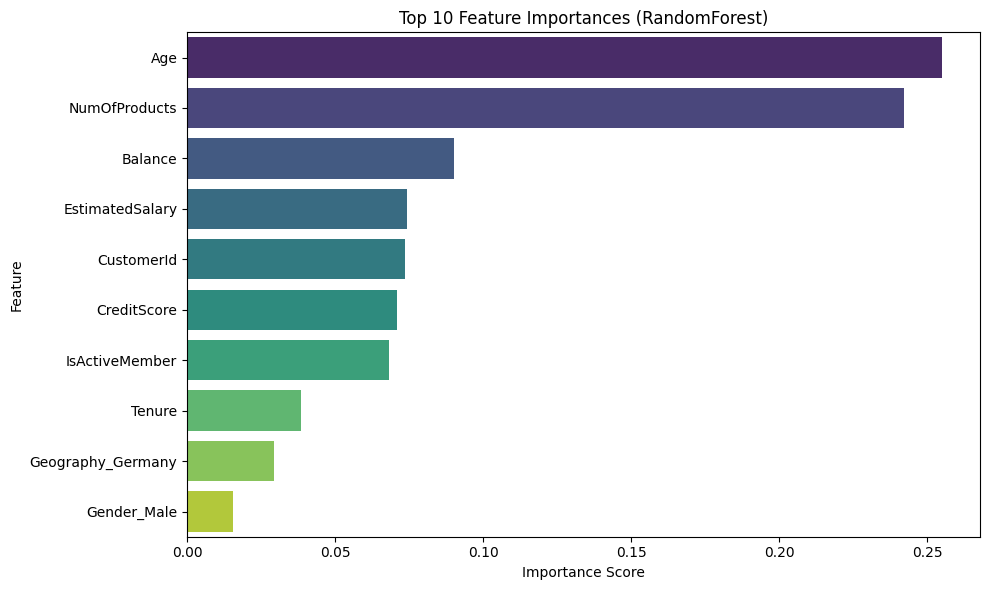

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 取得特徵重要性
importances = model.feature_importances_
features = X_train.columns

# 組成 DataFrame 並排序
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(10)

# 繪製 bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Top 10 Feature Importances (RandomForest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


特徵與目標變數的關聯

In [ ]:
# sns.barplot(x='features', y='target', data=data)


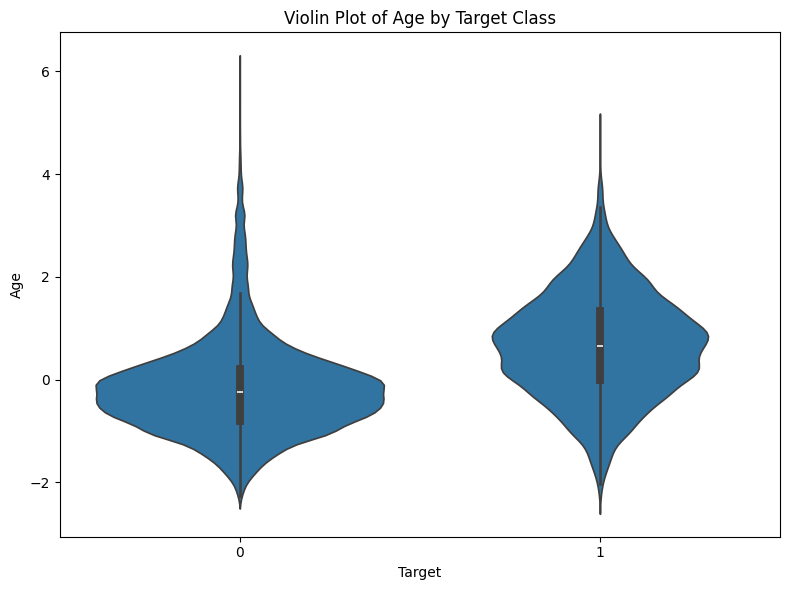

In [ ]:
# 以最重要特徵為例
top_feature = feat_imp_df.iloc[0]['Feature']

plt.figure(figsize=(8, 6))
sns.violinplot(x=y_valid, y=X_valid[top_feature])
plt.title(f'Violin Plot of {top_feature} by Target Class')
plt.xlabel('Target')
plt.ylabel(top_feature)
plt.tight_layout()
plt.show()


#交叉驗證

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
import numpy as np

# 資料示範
X, y = load_iris(return_X_y=True)

# 建立目標函數
def objective(trial):
    # 定義待調參數
    n_estimators = trial.suggest_int("n_estimators", 100, 300)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # 模型實例化
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    # 使用 StratifiedKFold 做交叉驗證
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")

    return np.mean(scores)

# 建立與執行 study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 最佳參數
print("Best trial:", study.best_trial.params)


[I 2025-06-18 12:16:45,817] A new study created in memory with name: no-name-30408735-215f-4d5e-a4e1-dae77305aa06
[I 2025-06-18 12:16:48,596] Trial 0 finished with value: 0.9600000000000002 and parameters: {'n_estimators': 219, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9600000000000002.
[I 2025-06-18 12:16:50,945] Trial 1 finished with value: 0.9600000000000002 and parameters: {'n_estimators': 196, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9600000000000002.
[I 2025-06-18 12:16:52,829] Trial 2 finished with value: 0.9600000000000002 and parameters: {'n_estimators': 109, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9600000000000002.
[I 2025-06-18 12:16:55,415] Trial 3 finished with value: 0.9600000000000002 and parameters: {'n_estimators': 160, 'max_depth': 4, 'min_

Best trial: {'n_estimators': 241, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}
